# Pricing Convertible Bonds with Least-Squared Monte Carlo model


**Author: René Brupbacher**

**Date: 17th April 2023**


## Abstract

Convertible Bonds (CBs) are hybrid instruments that simultaneously offer the potential upside participation of equities, while providing a limited downside in the form of a bond floor. This work aims at presenting how one may properly model a well-known market product, a path-dependent Puttable American CB. 

To simulate the underlying equity path, a stock price-based model is chosen such that the stock price (S) is stochastic and deterministic. This is done by maintaining the main input factors constant, namely, interest rate and stock volatility. Additionally, the Market is assumed to be complete and the stock time-series to follow a Geometric Brownian Motion. An enhancement to the latter is introduced in the form of a more realistic non-lognormal distribution for equity, by simulating random drawdowns representing market crashes, the consequence being a skewed and leptokurtic return distribution. For this, a jump-diffusion process with predefined probability and magnitude of the jumps is used.

Finally, modelling CBs with the possibility of early conversion (American Call style option) and alongside an option to Put the CB (European style option) at a predefined date in the future, a least-squared Monte Carlo (LSMC) method with backward induction technique is used.  In the modelling herewith presented, CB’s credit risk is assumed to be constant and independent from stock movement, for simplification.



## Table of content
- [Goals and Structure of the work](#id-section1)
- [Input Factors](#id-section2)
- [Calculating the Bond Floor over Time](#id-sectionBF)
- [Simulating the Stock path](#id-sectionSP)
- [Convertible Bond Modelling and Pricing](#id-sectionLSMC)
- [Pricing of pure Options for benchmarking purpose and to set the lower boundery](#id-sectionOP)
- [Sensitivity Analysis of the Pricing Model](#id-sectionPR)
- [Summary, conclusion and limitations of this work](#id-sectionRC)







<div id='id-section1'/>

## Goals and Structure of the work

The aim of this work is to provide a clear Python based code with the proposed pricing framework for modelling Convertible Bonds. With the correct pricing of these instruments at hand, one can identify, avoid, limit or even explore arbitrage opportunities. I will not go into much detail as to how a Convertible Bond works, and thus, I assume the reader has already a good understanding on the mechanics behind a CB.

The work is divided into following parts:

- I will first calculate the CB’s Bond-Floor in a matrix for each day of the life of the CB, with a Put option at a predefined date that gives the holder the right to redeem the Bond at a predefined price. The Bond-Floor is subject to the Risk Free Rate, the Credit Risk Spread and the Put Price/Redemption Price.

- I then will simulate possible stock paths of the CB’s underlying equity in a random number matrix by using Monte Carlo methods that follows the Geometric Brownian Motion with jumps to the downside to reflect a more realistic stock path that results in a non-lognormal distribution. 

- To price the CB a backward induction technique called Least-squared Monte Carlo is used

- To benchmark the result, I use a classical Black-Scholes pricing model used for European options

- A sensitivity analysis is shown on how the model behaves with various input assumptions

- Lastly, I will summarize, make a conclusion and discuss the limitation of this work

Furthermore, I seed the random number generator in order to be able to discuss the model's output in this work.

In [1]:
import numpy as np
import numpy.random as npr
import math
import scipy.stats as scs
from pylab import mpl, plt

%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

<div id='id-section2'/>

## Input Factors

The following tables are the required inputs for the model:

&nbsp;


| CB feature/terms||     
| :- |-------------: |
| CB life| 5 years  |
| Conversion Price (Strike) | 65.00 |
| Coupon Rate | 3.0% |
| Coupon payment frequency | semi-annual |
| Credit Risk Spread | 5.0% |
| Redemption Price | 100% |
| Conversion Period | American Style during CB's life |
| Put Price | 100% |
| Put Period | European Style after 2 years | 


| Underlying Stock ||     
| :- |-------------: |
| Initial Stock price | 50.00  |
| Volatility | 20%  |
| Jump Probability | 10%  |
| Jump Magnitude| -60%  |
| Jump Standard Deviation | 25%  |



| Market rates||     
| :- |-------------: |
| Flat Risk Free Rate | 1.6% (p.a.)  |

&nbsp;
&nbsp;









In [3]:
S0 = 50.  # stock at t0
K = 65.  # cb conversion price

Pt = 100.  # put value
Pt_start = 250 * 2  # put start period

r = 0.016  # annual risk free rate
cs = 0.05  # credit spread associated with issuer's credit risk

T = 5  # time horizon to cb maturity (years).
sigma = 0.20  # stock volatility

# number of time intervals. (number of working days during cb's life)
M = 250 * T
I = 10000  # number of paths

dt = T / M  # expresses 1 day as a fraction of the life of the cb
df = math.exp(-r * dt)  # discountfactor per day

In [4]:
# Fixes the seed value for reproducibility
np.random.seed(100)

<div id='id-sectionBF'/>

## Calculating the Bond Floor over Time

The below calculates Bond Floor over the life of the Convertible Bond with an Put Option (European style) at 100 after 500 days (2 years). After the Put date, the Bond Floor drops as it is re-calculated based on remaining life to maturity.

In [5]:
def bond_floor(risk, credit, n_days, n_paths):
    """calculates the bond floor over the cb's life 

    parameters:
        risk (float): annual risk free rate
        credit (float):  issuer's credit risk
        n_days (float):  number of working days during cb's life
        n_paths (float):  number of simulated stock paths    

    Returns:
        B (float): bond floor as a decimal number based on the inputs above
    """

    pmt = 2  # coupon frequency per period

    ytm = r + cs  # current market yield to maturity e.g. risk-free rate & flat credit risk
    fv = 100  # redemption Value at Maturity
    c = 0.03  # coupon rate

    # a two-dimensional ndarray object of a shape that corresponds with number of paths and
    # time of the stock simulation is instantiated.
    B = np.zeros((M + 1, I))

    for t in range(0, M+1, 1):

        # decision tree to check whether current period is before, during, or after put period
        # to define bond floor

        if t < (Pt_start):

            # time left to put (e.g. the first 2 years)
            iii = (Pt_start - t) / 250

            # calculates the bond floor to Put
            B[t] = ((Pt*c/pmt*(1-(1+ytm/pmt)**(-pmt*iii)))/(ytm/pmt)) + \
                Pt*(1+(ytm/pmt))**(-pmt*iii)

        elif t >= (Pt_start) and t <= (Pt_start) + 1:

            B[t] = Pt  # cb putable at 100 if time (t) is between 500 and 501

        else:

            ii = (M - t) / 250  # time left to maturity (e.g. the last 3 years)

            B[t] = ((fv*c/pmt*(1-(1+ytm/pmt)**(-pmt*ii)))/(ytm/pmt)) + \
                fv*(1+(ytm/pmt))**(-pmt*ii)  # calculates new bond floor

    return B

In [6]:
BF = bond_floor(r, cs, M, I)

Floor = BF[0].mean()  # bond floor at t0 for the cb

The below chart illustrates the Bond Floor over the life of the Convertible Bond. After 500 working-days, the CB is puttable at 100 during one day. Thereafter, the bond price drops to its new natural floor based on the redemption value and remaining life as the put is no longer active.

The Bond Floor for the CB at t0 is: 93.36


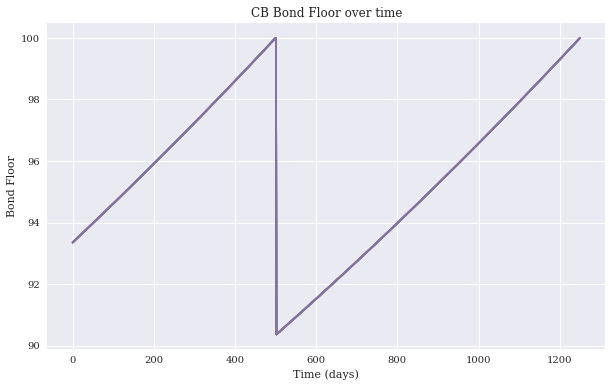

In [7]:
plt.figure(figsize=(10, 6))
plt.title('CB Bond Floor over time')
plt.plot(BF[:, :10])
plt.xlabel('Time (days)')
plt.ylabel('Bond Floor')
print('The Bond Floor for the CB at t0 is: ' +
      str(float("{0:.2f}".format(Floor))))

The below calculates Bond Floor over the life of a straight Bond without any optionality.

In [8]:
SB = np.zeros(M + 1)

pmt = 2  # coupon frequency per period

ytm = r + cs  # current market yield to maturity e.g. risk-free rate & flat credit risk
fv = 100  # redemption Value at maturity
c = 0.03  # coupon rate

for t in range(0, M+1, 1):
    k = (M - t) / 250  # time left to maturity
    SB[t] = ((fv*c/pmt*(1-(1+ytm/pmt)**(-pmt*k))) /
             (ytm/pmt)) + fv*(1+(ytm/pmt))**(-pmt*k)

B_floor = SB[0]

The Bond Floor for the CB at t0 is: 84.88


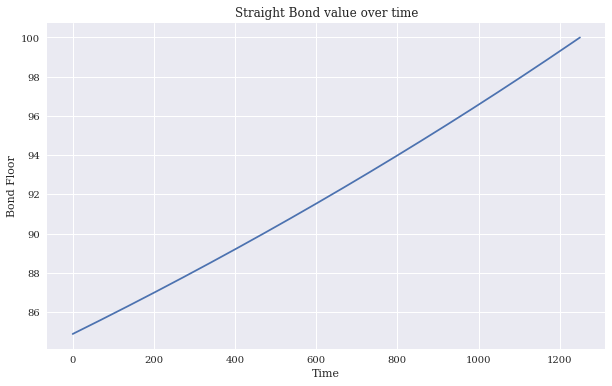

In [9]:
plt.figure(figsize=(10, 6))
plt.title('Straight Bond value over time')
plt.plot(SB)
plt.xlabel('Time')
plt.ylabel('Bond Floor')
print('The Bond Floor for the CB at t0 is: ' +
      str(float("{0:.2f}".format(B_floor))))

<div id='id-sectionSP'/>

## Simulating the stock path

The single stock price paths are simulated based on the initial stock prices for the stochastic components with regular Monte Carlo, the random number matrix and the difference equation for the geometric Brownian motion.


The below parameters for the Jumps (probability, magnitude and standard deviation) are estimates only. However, it's worthwhile to note that jumps should be calibrated to Credit Default Swap of the issuer (e.g. the higher the CDS, the higher the probability). In this work, I assume the below constant estimates of jumps for any credit spread and the company will always honour its debt liability.

In [10]:
# jump parameters

lamb = 0.1  # jump probability
mu = -0.60  # stock Jump
delta = 0.25  # standard deviation of jump

In [11]:
def stock_simulation(jump_prob, jump_mag, jump_vol, stock_vol, stock_0, n_days, n_paths, day_fract, risk):
    """simulates different stock price paths during the life of the cb, including shocks in the forms of jumps to the 
        the downside.

    parameters:
        jump_prob (float): jump probability
        jump_mag (float): stock Jump magnitude
        jump_vol (float_): standard deviation of jump size
        stock_vol (float): stock volatility
        stock_0 (float): stock at T=0
        n_days (integer): number of working days during cb's life
        n_paths (integer): number of simulated stock paths
        day_fract (float): 1 day as a fraction of the life of the cb 
        risk (float): annual risk free rate 

    Returns:
        S (array object): stock simulation path with jumps
    """

    # fixes the seed value for reproducibility
    np.random.seed(100)

    # drift correction for jump to maintain risk neutrality
    rj = jump_prob * (np.exp(jump_mag + 0.5 * jump_vol ** 2) - 1)

    # a two-dimensional ndarray object of the same shape is instantiated and
    # the initial values for the single stock price paths are set.
    S = np.zeros((n_days + 1, n_paths))
    S[0] = stock_0  # initial stock level at t0

    # the first set of standard normally distributed random numbers
    sn1 = npr.standard_normal((n_days + 1, n_paths))
    # the second set of standards normally distributed random numbers
    sn2 = npr.standard_normal((n_days + 1, n_paths))
    # poisson-distributed pseudorandom numbers for the jump component
    poi = npr.poisson(jump_prob * day_fract, (n_days + 1, n_paths))

    for t in range(1, M + 1, 1):  # selects the right time slice from the relevant random number set

        # the simulation of the stock price values at t given the sets of random numbers
        S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * stock_vol ** 2) * day_fract
                           + stock_vol * np.sqrt(day_fract) * sn1[t])
                           + (np.exp(jump_mag + jump_vol * sn2[t]) - 1)
                           * poi[t])

        # maximum function to avoid negative values for the stock price
        S[t] = np.maximum(S[t], 0)

    return S

In [12]:
# simulating stock path

S = stock_simulation(lamb, mu, delta, sigma, S0, M, I, dt, r)

#### Plotting the first 10 simulated paths
The below charts plots the first 10 simulated stock paths with random jumps to the downside. 

Text(0, 0.5, 'Stock Level')

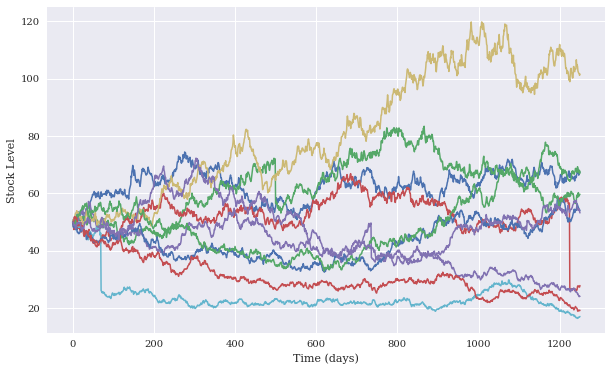

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('Time (days)')
plt.ylabel('Stock Level')

#### Distribution Chart of Stock prices

To visually show the distribution of the stock prices, a histogram is shown below. To statistically test the distribution characteristics, Skew and Kurtosis is calculated with the help of SciPy.

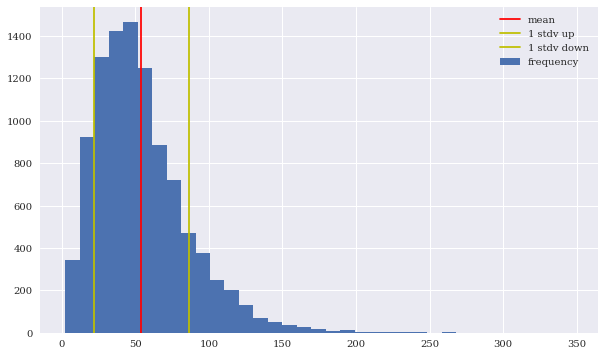

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=35, label='frequency')
plt.axvline(S[-1].mean(), color='r', label='mean')
plt.axvline(S[-1].mean() + S[-1].std(), color='y', label='1 stdv up')
plt.axvline(S[-1].mean() - S[-1].std(), color='y', label='1 stdv down')
plt.legend(loc=0)

#### Skewness and Kurtosis of Stock returns



In [15]:
def print_statistics(array):
    """computes several descriptive statistics of the stock prices."""

    sta = scs.describe(array)

    print("%14s %15s" % ('statistic', 'value'))
    print("%30s" % (25 * "-"))
    print("%14s %15.5f" % ('skew', round(sta[4], 2)))
    print("%14s %15.5f" % ('kurtosis', round(sta[5], 2)))

In [16]:
print_statistics(S.flatten())

     statistic           value
     -------------------------
          skew         1.26000
      kurtosis         4.96000


- If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
- If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
- If skewness is between -0.5 and 0.5, the distribution is approximately symmetric. 
- If Kurtosis is above 3, then the distribution has heavier tails than a normal distribution




A skew value of above 1 in a Stock Model is indicating a long tail on the right side (positive skew). This is expected as equity values cannot go below zero but have unlimited upside. A kurtosis above 3 is known as leptokurtic distribution. Characteristics of this type of distribution is one with long tails (outliers) and hence, occasional extreme values. Given the above values for Skewness and Kurtosis, I am confident that the stock returns follow a non-lognormal distribution.

<div id='id-sectionLSMC'/>

## Convertible Bond Modelling and Pricing


The specified Convertible Bond presents both a holder call and put clause. The call can be exercised at any given time step and stock is received if the continuation value is below the parity value. On the other hand, the put can be exercised after two years and thus altering the bond floor. The inner value of the CB is the maximum of parity or the Bond Floor. 

For pricing this Convertible Bond using Monte Carlo methods, stock price paths have been simulated. Then, at each time step, for each path I calculate the continuation value with the help of a polynomial regression. I then evaluate if the inner value exceeds the continuation value. If this is the case, the inner value is used, else the previous continuation value is discounted. For the last step before t0, the present value is calculated as the average over the calculated CB Value vector derived from the LSMC model and discounted one more day to the present.

In [17]:
def lsmc(stock_sim, strike_price, bond_floor, n_days, day_fract):
    """calculates the cb fair value as of today.

    parameters:    

        stock_sim (array object): stock simulation over the life of the cb
        strike_price (float): cb conversion price 
        bond_floor (array object): bond floor over the life of the cb
        n_days (integer): number of working days during cb's life
        day_fract (float): 1 day as a fraction of the life of the cb

    Returns:
        theo_CB (float): theoretical cb price at t=0 by using the least-squares monte carlo valuation
    """

    # fixes the seed value for reproducibility
    np.random.seed(100)

    df = math.exp(-r * day_fract)  # discount factor

    # inner Value matrix (max of parity or bond floor) over all stock price path
    h = np.maximum.reduce([stock_sim / strike_price * 100, bond_floor])

    # sets the initial simulated CB price values to the inner values at maturity
    V = h[-1]

    # the algorithm works based on backwards induction starting at M-1 and then going backwards to 0
    for t in range(n_days-1, 0, -1):

        # Returns a vector of coefficients that minimises the squared error
        reg = np.polyfit(stock_sim[t], df * V, deg=5)
        # Evaluates the polynomial (continuation value) at specific stock values
        C = np.polyval(reg, stock_sim[t])

        # If the inner CB value (h) is higher than the approximated continuation value (C),
        # conversion would take place. for in-the-money CBs and for out-of-the money CBs the 
        # bond floor is triggered. both mechanics would force the cb back to its inner value. 
        # in all other cases, the discounted simulated cb price prevails.
        V = np.where(h[t] > C, h[t], df * V)

    # the pv is calculated as the average over the calculated cb value vector
    # as derived based on the lscm algorithm and discounted for
    # the last remaining time interval to the present (t=0).
    theo_CB = df * V.mean()

    return theo_CB

In [18]:
theo_CB_calc = lsmc(S, K, BF, M, dt)

In [19]:
print('CB theoretical value is: ' + str(float("{0:.2f}".format(theo_CB_calc))))
print('CB Bond Value is: ' + str(float("{0:.2f}".format(Floor))))
print('CB Option Value is: ' +
      str(float("{0:.2f}".format(theo_CB_calc - Floor))))

CB theoretical value is: 104.14
CB Bond Value is: 93.36
CB Option Value is: 10.78



The specified Convertible Bond has a theoretical price of 104.14. This can be split between the Bond value (93.36) and the option value (10.78). 



<div id='id-sectionOP'/>

## Pricing of pure Options for benchmarking purpose and to set the lower boundery

To benchmark the theoretical CB value from the LSMC model, I calculate the value of a plain vanilla European Stock Call Option and Bond Put Option. For the call option is use the the Black-Scholes model, and for the Bond Put option, I am using the Black-76 model which is a variant of the Black-Sholes option pricing model. After both Option values have been calculated, I add the Bondfloor (bond component) from the straight bond to the Option values in order to make it comparable to the LSMC CB price. This compination should act as a lower boundery which the CB's theortical value should not breach.

#### Five year European Call Option with Black-Scholes model
Having the simulated stock price values already available, the same stock simulation is used for the model model. To price the European Call options, it is only a matter of two more vectorised operations as seen below. 

In [20]:
# the payoff vector of the Call option
CaT = np.maximum(S - K, 0)  
# the monte carlo estimator of the option price discounted to t0
C0 = math.exp(-r * T) * CaT.mean()
print('Call Option Value is: ' + str(float("{0:.2f}".format(C0))))

Call Option Value is: 3.45


#### Two year European Put Option with Black-76 model
For the implied volatility in the model, I use an simplified assumption that the volatility equals the Macaulay duration of zero coupon bond with 5 years to maturity. E.g. the volatility number equals the number of years. 

In [21]:
# inputs
K_b = Pt  # put Price
r_b = r  # risk free rate
sigma_b = T / 100  # estimate of the Implied volatility for the underlying price
T_b = Pt_start / 250  # time to put in years
Fwd_b = SB[500]  # forward price of straight bond in two years

# calculation
dt_b = sigma_b * np.sqrt(T_b)
d1 = (math.log(Fwd_b / K_b)+(0.5 * sigma_b ** 2) * T_b) / dt_b
d2 = d1 - dt
nd1 = scs.norm.cdf(d1)
nd2 = scs.norm.cdf(d2)
nnd1 = scs.norm.cdf(-d1)
nnd2 = scs.norm.cdf(-d2)


P0 = math.exp(-r_b * T_b) * (K_b * nnd2 - Fwd_b * nnd1)

print('Put Option Value is: ' + str(float("{0:.2f}".format(P0))))

Put Option Value is: 8.65


In [22]:
CPB = C0 + P0 + B_floor  # call + put + straight Bond

print('Value of pure Option (Call & Put) & Bond Floor is: ' +
      str(float("{0:.2f}".format(CPB))))
print('CB theoretical value from the LSMC model is: ' +
      str(float("{0:.2f}".format(theo_CB_calc))))
print('Absolute difference is: ' +
      str(float("{0:.2f}".format(theo_CB_calc - B_floor - C0 - P0))))
print("CB premium is: "+"{:.2%}".format((theo_CB_calc-CPB)/CPB))

Value of pure Option (Call & Put) & Bond Floor is: 96.98
CB theoretical value from the LSMC model is: 104.14
Absolute difference is: 7.16
CB premium is: 7.38%


The sum of the European option values plus the straight bond represents a lower boundary of the CB theoretical value. The difference is generally called the early exercise premium for the American Call in the CB. Hence, the theoretical value in the LSMC pricing model should not drop below the sum of the pure option values plus the bond component.
As one can be seen from the values above, the theoretical CB value is approx. 7.4% higher when compared to the traditional pure option & bond value.

<div id='id-sectionPR'/>

## Sensitivity Analysis of the Pricing Model

In this section, I review the behaviour of the pricing model using the relevant risk factors (underlying equity, volatility,  and credit spread). The below charts shows the sensitivity of the model to these four risk factors. I assume that the other parameters remain unchanged.

In [23]:
# calculating fair value based on different volatility levels

CB_array_Vol = []
Vol_array = []

S0 = 50.
r = 0.016
cs = 0.05

for i in np.arange(0.01, 0.4, 0.01):
    sigma = i
    
    S_vol = stock_simulation(lamb, mu, delta, sigma, S0, M, I, dt, r)
    
    theo_CB_calc_vol = lsmc(S_vol, K, BF, M, dt)
    
    CB_array_Vol.append(theo_CB_calc_vol)
    
    Vol_array.append(i)

In [24]:
# calculating Fair Value based on different credit spreads

CB_array_CS = []
cs_array = []

S0 = 50.
r = 0.016


# adjusting credit spreads from 0.01 to 0.30 with 0.01 steps
for i in np.arange(0.01, 0.30, 0.01):
    cs = i
   
    BF_cs = bond_floor(r, cs, M, I)
    
    theo_CB_calc_cs = lsmc(S, K, BF_cs, M, dt)

    CB_array_CS.append(round(theo_CB_calc_cs, 1))
    
    cs_array.append(i)

In [25]:
# calculating fair value based on different prices of the underlying

CB_array_EQ = []
EQ_array = []

sigma = 0.2
r = 0.016
cs = 0.05

for i in range(1, 150, 10):
    S0 = i
    
    S_stock = stock_simulation(lamb, mu, delta, sigma, S0, M, I, dt, r)

    theo_CB_calc_stock = lsmc(S_stock, K, BF, M, dt)

    CB_array_EQ.append(theo_CB_calc_stock)
    
    EQ_array.append(i)

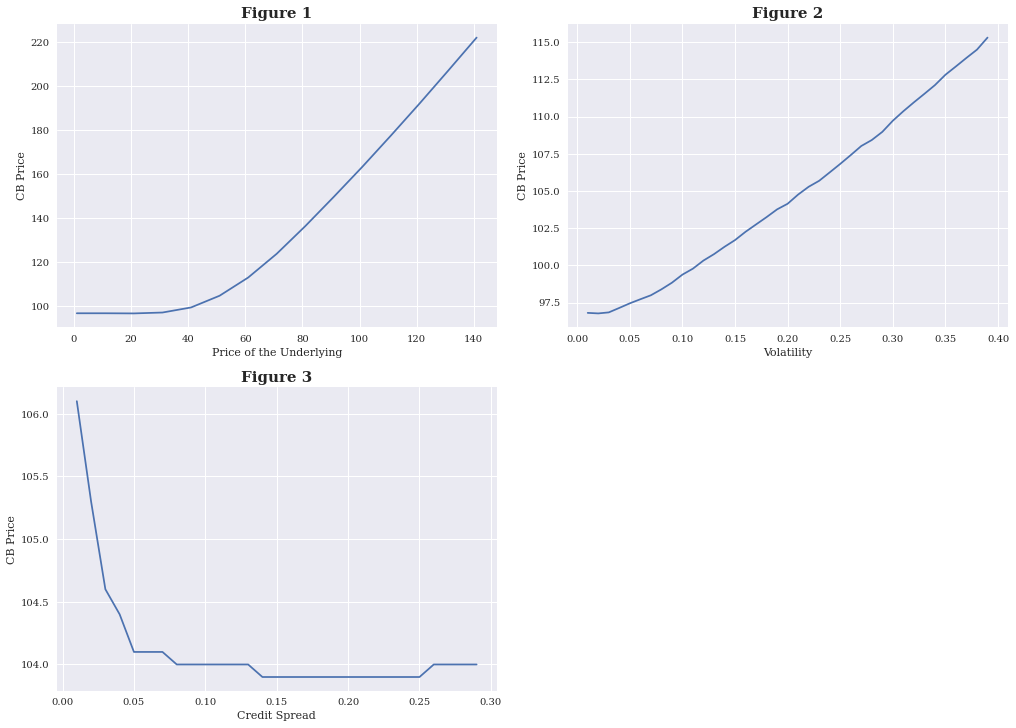

In [26]:
figure, axis = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

Y1 = CB_array_EQ
X1 = EQ_array
Y2 = CB_array_Vol
X2 = Vol_array
Y3 = CB_array_CS
X3 = cs_array

axis[0, 0].plot(X1, Y1)
axis[0, 0].set_xlabel('Price of the Underlying')
axis[0, 0].set_ylabel('CB Price')
axis[0, 0].set_title('Figure 1', size=15, fontweight="bold")

axis[0, 1].plot(X2, Y2)
axis[0, 1].set_xlabel('Volatility')
axis[0, 1].set_ylabel('CB Price')
axis[0, 1].set_title('Figure 2', size=15, fontweight="bold")

axis[1, 0].plot(X3, Y3)
axis[1, 0].set_xlabel('Credit Spread')
axis[1, 0].set_ylabel('CB Price')
axis[1, 0].set_title('Figure 3', size=15, fontweight="bold")

plt.delaxes(axis[1, 1])

plt.show()

Figure 1 shows the sensitivity of the model to the underlying price of the CB. According to the figure, the price of the CB is an increasing function of the price of the underlying equity due to the conversion option. That means the CB price converges to parity in case of "in-the-money" CBs, and converges to the bond floor in case of "out-the-money" CBs.

Figure 2 shows the sensitivity of the model to the volatility of the underlying equity. When volatility increases, the value of the conversion option and therefore the price of the CB increases. 

Figure 3 shows the sensitivity of the model to credit spread changes. In this case, the CB price decreases when credit spread increases. This is not too surprising as a CB is basically a bond plus the call option. Worthwile mentioning is, that while the credit spread incrases, the CB price is not decrasing over all credit spreads. This is due to the embedded put option in the CB, which acts as a floor that defines the lower bound of the bond value regardless of the credit spread. 

<div id='id-sectionRC'/>

## Summary, conclusion and limitations of this work

In this work, I have presented a concept to model and price a Convertible Bond with American Call and European Put features. I believe I have successfully demonstrated how to use the LSMC, a method to cope with these features. With the help of a traditional Black-Scholes model for the Stock Call option, and a Black-76 model for the Bond Put option, I was able to estimate the synthetically replicate these features, and hence to benchmark the CB's theoretical value derived from the LSMC model. 

Throughout this work, I have assumed a constant credit risk. However, variations in credit risk do indeed impact the Convertible Bond price. Thus, a very natural extension one shall consider is to include a credit risk profile over the life of the CB. Similar, as I have assumed a fixed interest rate level, extending the provided pricing framework to a setting where the interest rate follows a given term structure might be advisable.

Another important aspect of this work is the model's sensibility to stock volatility. The model  uses a constant and deterministic stock volatility. In real world, future stock movements are not a predefined parameter, but rather retrieved from market data. This volatility effect poses a serious limitation for general use of LSMC methods to price Convertible Bonds. A possible extension to the presented pricing framework could be to consider a model where the volatility is not constant and deterministic but stochastic.

Furthermore, to price a bond put option is not as straight forward as I have hoped it is, as it requires assumptions about interest rate volatility. This in itself could already be an academic paper which is out of scope for the purpose of this work, and thus I have used rather naïve assumptions.

Lastly, the value derived from the benchmarking has some flaws when compared to a true convertible bond. For example, the options embedded in a convertible bond are not detachable from the bond. Instead, the debt is converted into equity upon conversion, and at some point there is no debt, but just more shares. Another limitation is that call options typically require investors to make an additional payment within a specified time frame in order to exercise it and receive stock in exchange. Funds can be obtained by selling the straight bond, but the value is not certain and additional funds may be required at extra cost. 